<a href="https://colab.research.google.com/github/Rsimetti/cursoAP2020/blob/master/Semana4_Analise_de_Agrupamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade da Semana 4 - Análise de Agrupamento

Essa atividade consiste em:

- criar um notebook no Google Colab
- realizar a leitura dos dados com pandas 
- realizar a limpeza e organização dos dados para modelagem
- utilizar os algoritmos de agrupamento apresentados na semana
- realizar a análise e interpretação dos resultados obtidos
- incluir as análises no notebook.





## Montagem do drive e importar bibliotecas

In [123]:
# Montaagem do drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [144]:
# Bibliotecas básicas para operações do daddos e gráficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Divisão dos dados para treino e teste
from sklearn.model_selection import train_test_split 

# Redução dimensional
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Facilitadores da transformação 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Métodos de agrupamento
from sklearn.cluster import (KMeans, 
                             AgglomerativeClustering)

# Métricas de desempenho 
from sklearn.metrics import (accuracy_score, 
                             # para casos conhecidos (rotulados)
                             adjusted_rand_score,
                             adjusted_mutual_info_score, 
                             fowlkes_mallows_score)

## Leitura e organização dos dados

Realizamos a leitura dos dados e seguimos em diante nas análises pois esse banco de dados já foi previamente estudado em outra situação, sendo conhecida sua estrutura e o fato de não apresentar dados faltantes ou outliers.
Os dados foram separados em traino e teste para avaliar os métodos utilizados, a proporção foi de 70% para treino e 30% para teste.

In [126]:
da = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dados/milk.csv")

In [127]:
# Separação em variáveis explicativas (X) e variável resposta (Y)
X = da.values[0:,2:].astype('float32')
Y = da.values[0:,1]
# Gerando os rótulos para os comprimentos do onda
wl = np.linspace(1102, 2300, 601)

In [128]:
# Separação em teste e treino
X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, 
                     test_size = 0.3, 
                     stratify = Y,
                     random_state = random_state)

# Transformando os objetos Y em int 
Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')

## Análise exploratória dos dados

Os [dados analisados](https://github.com/nevernervous78/nirpyresearch/blob/master/data/milk.csv) são referentes a misturas de leite que se diferenciam pela quantidade de leite e leite sem lactone na mistura. O espectro do infravermelho próximo foi obtido em nove misturas diferentes, sendo realizadas 50 leituras em cada mistura, totalizando 450 amostras.

Por meio dos espectros podemos observar que não distinção clara entre as amostras.

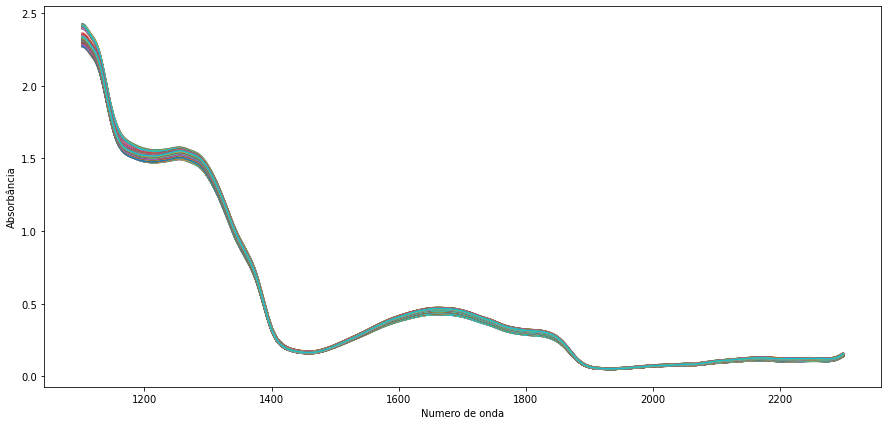

In [146]:
plt.subplots(figsize = (15, 7))
plt.plot(wl, X.T)
plt.ylabel("Absorbância")
plt.xlabel("Numero de onda")
plt.show()

Os espectros obtidos no infravermelho próximo apresentam redundância de informação em diferentes comprimentos de onda, isso pode ser observado utilizando-se a correlação linear de Pearson. Na figura abaixo podemos visualizar que existem coeficientes de correlação elevados, principalmente, para comprimentos de onda próximos. 

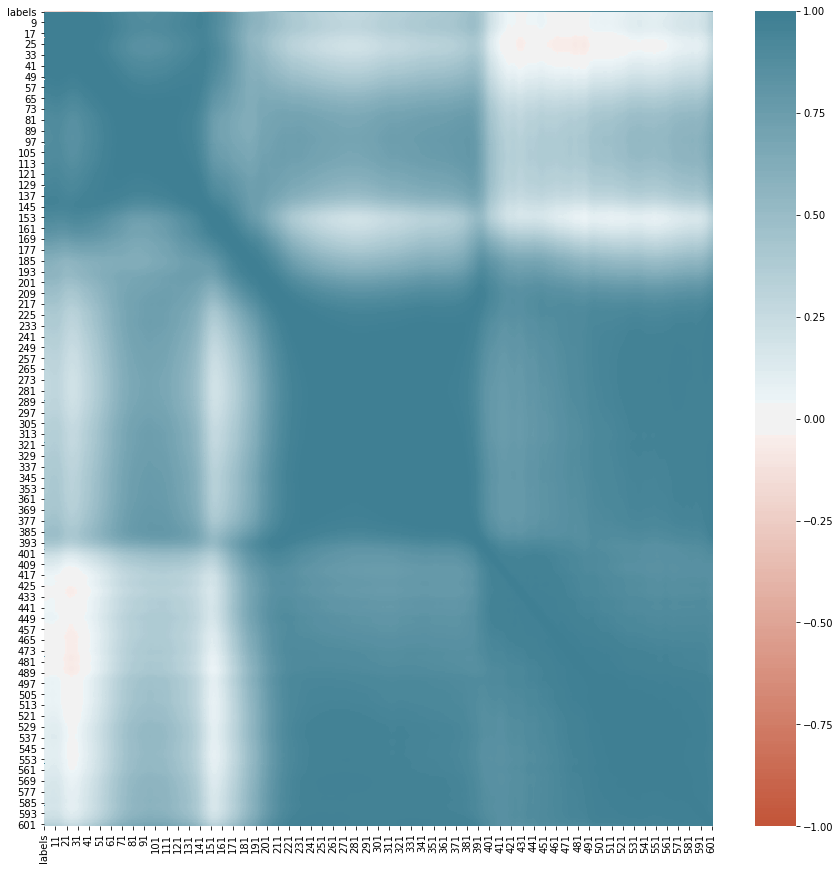

In [130]:
# Calcular correlação
correlacao = da.corr()

# Plotar gráfico correlação
plt.subplots(figsize = (15, 15))
sns.heatmap(correlacao,
            vmin = -1, 
            vmax = 1, 
            center = 0,
            cmap=sns.diverging_palette(20, 220, n = 200))

Para reduzir a redundância de informações presentes nos dados foram adotados métodos de redução dimensional nos dados. As técnicas usadas foram:

*   Análise de componentes principais (ACP)
*   Análise de discriminante linear (ADL)

Destaca-se que a ACP é uma técnica não supervisionada, ou seja, não utiliza os rótulos dos dados e máximiza o espalhamento dos padrões no espaço, enquanto a LDA é uma técnica supervisionada que busca máximizar a variação entre as classes. As técnicas aplicadas tem em comum o fato que geram novas variaveis que são combinações lineares da variaveis originais. 




In [147]:
# Definindo o número de componentes / variaveis usadas
n_components = 9
dim = len(X[0])
n_classes = len(np.unique(Y))

# Redução dimensional com PCA
pca = make_pipeline(StandardScaler(),
                    PCA(n_components = 3, 
                        random_state = random_state))
# Redução dimensional com LDA
lda = make_pipeline(StandardScaler(),
                    LinearDiscriminantAnalysis(n_components = 3))

# Armazenando os métodos em uma lista
dim_reduction_methods = [('ACP', pca), ('ADL', lda)]

## Análise de agrupamento

Realizamos duas técnicas de agrupamento: K-means e Hierárquico Aglomerativo. 
Em ambas os índices de avaliação utilizados consideraram os dados já rotulados. 

### Agrupamento K-means

Iremos realizar a análise duas vezes, uma para o lote de treino e outra para o lote de teste. Isso para podermos comparar com o próximo método.

In [161]:
# Agrupamento K-means
kmeans = KMeans(n_clusters=9, init = "random")

<Figure size 432x288 with 0 Axes>

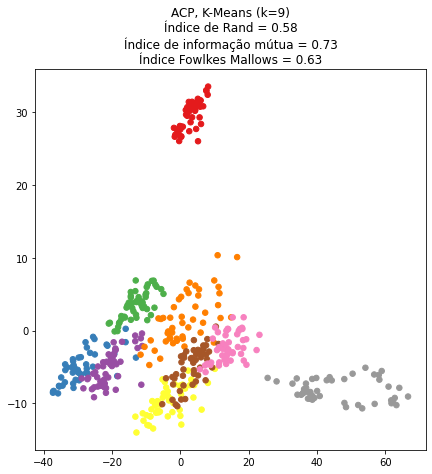

<Figure size 432x288 with 0 Axes>

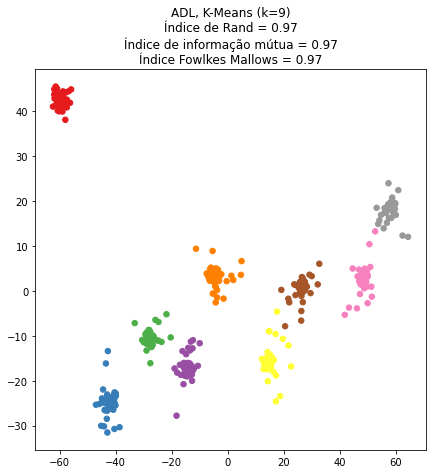

In [162]:
# Predição no lote de teste
# Código adaptado, original para Knn 
# Fonte: https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py
# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    plt.subplots(figsize = (7, 7))
    # plt.subplot(1, 2, i + 1, aspect=1)

    # Ajusta o método de redução dimensional (RD)
    model.fit(X_train, Y_train)

    # Realiza o k means para cada RD
    kmeans.fit(model.transform(X_train))

    # Fazendo a predição no lote de teste
    kmeans_labels = kmeans.predict(model.transform(X_test))
    # Cakcykabdi as métricas
    metrica_rand = adjusted_rand_score(Y_test,kmeans_labels)
    metrica_mut_info = adjusted_mutual_info_score(Y_test,kmeans_labels)
    metrica_fm = fowlkes_mallows_score(Y_test,kmeans_labels)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y, s=30, cmap='Set1')
    plt.title("{}, K-Means (k={})\nÍndice de Rand = {:.2f}\nÍndice de informação mútua = {:.2f}\nÍndice Fowlkes Mallows = {:.2f}".format(name, n_components, metrica_rand,metrica_mut_info, metrica_fm))
plt.show()

<Figure size 432x288 with 0 Axes>

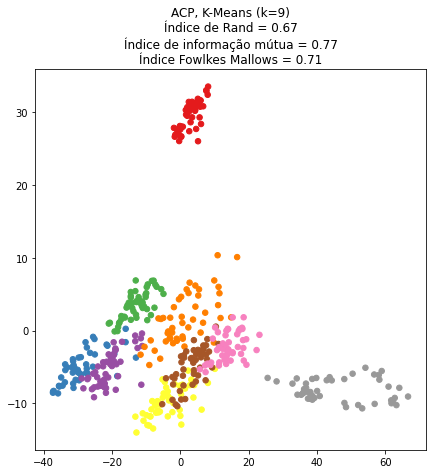

<Figure size 432x288 with 0 Axes>

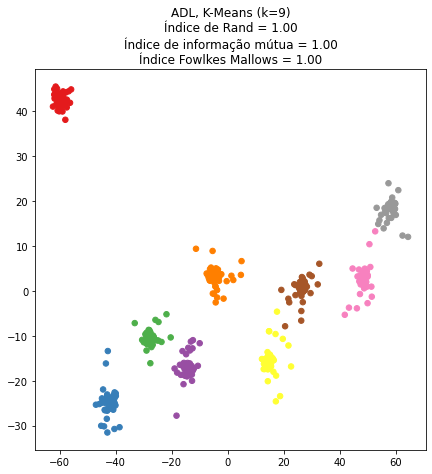

In [165]:
# Predição no lote de treino
# Código adaptado, original para Knn 
# Fonte: https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py
# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    plt.subplots(figsize = (7, 7))
    # plt.subplot(1, 2, i + 1, aspect=1)

    # Ajusta o método de redução dimensional (RD)
    model.fit(X_train, Y_train)

    # Realiza o k means para cada RD
    kmeans.fit(model.transform(X_train))

    # Fazendo a predição no lote de teste
    kmeans_labels = kmeans.predict(model.transform(X_train))
    # Cakcykabdi as métricas
    metrica_rand = adjusted_rand_score(Y_train,kmeans_labels)
    metrica_mut_info = adjusted_mutual_info_score(Y_train,kmeans_labels)
    metrica_fm = fowlkes_mallows_score(Y_train,kmeans_labels)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y, s=30, cmap='Set1')
    plt.title("{}, K-Means (k={})\nÍndice de Rand = {:.2f}\nÍndice de informação mútua = {:.2f}\nÍndice Fowlkes Mallows = {:.2f}".format(name, n_components, metrica_rand,metrica_mut_info, metrica_fm))
plt.show()

### Agrupamento Hierárquico Aglomerativo

In [155]:
# Agrupamento Hierárquico Aglomerativo
hierarquico = AgglomerativeClustering(n_clusters=9)

<Figure size 432x288 with 0 Axes>

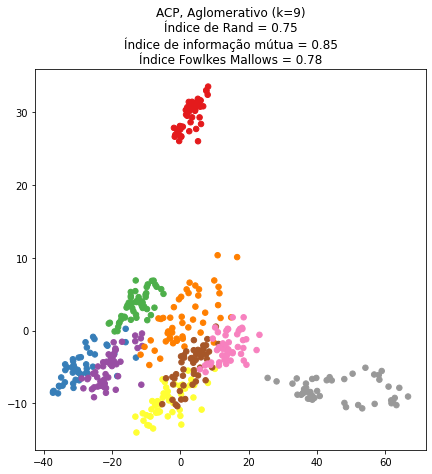

<Figure size 432x288 with 0 Axes>

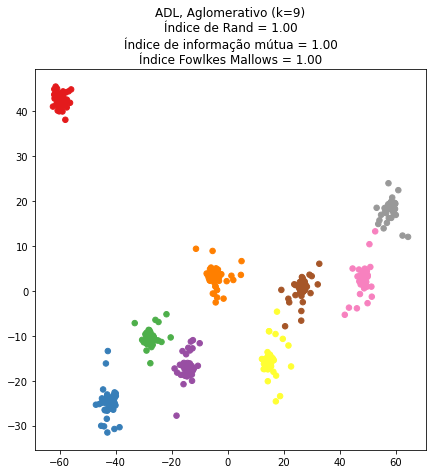

In [160]:
# Código adaptado, original para Knn 
# Fonte: https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py
# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    plt.subplots(figsize = (7, 7))
    # plt.subplot(1, 2, i + 1, aspect=1)

    # Ajusta o método de redução dimensional (RD)
    model.fit(X_train, Y_train)

    # Realiza o k means para cada RD
    hierarquico_labels = hierarquico.fit(model.transform(X_train)).labels_

    # Fazendo a predição no lote de teste
    # Cakcykabdi as métricas
    metrica_rand = adjusted_rand_score(Y_train,hierarquico_labels)
    metrica_mut_info = adjusted_mutual_info_score(Y_train,hierarquico_labels)
    metrica_fm = fowlkes_mallows_score(Y_train,hierarquico_labels)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y, s=30, cmap='Set1')
    plt.title("{}, Aglomerativo (k={})\nÍndice de Rand = {:.2f}\nÍndice de informação mútua = {:.2f}\nÍndice Fowlkes Mallows = {:.2f}".format(name, n_components, metrica_rand,metrica_mut_info, metrica_fm))
plt.show()

## Considerações finais

Para o banco de dados utilizado podemos concluir que:

*   O agrupamento hierárquico aglomerativo foi superior ao K-means, mas esta primeira técnicas apresenta a desvantagem de não poder ser utilizada para predições, só classificando os indiduos já existentes.
*   A ADL foi superior à ACP em ambos os métodos aglomerativos, isso está ligado ao fato desta técnica já separar previamente os grupos máximizando a disttância entre eles. Nos casos de apenas usar o lote de treino as duas técnicas associadas conseguiram 100% de acerto da classe das amostras.
*   Entre os índices utilizados para avaliação dos modelos, o de Rand sempre apresentou os menores valores, seguido pelo de Fowlkes Mallows e depois pelo de informação mútua. Porém o valor dos três índices foi de 0,97 para o caso do lote de teste quando aplicado k-means e ADL.

Ténicas da agrupamento associadas com espectro do NIR já são aplicadas em diversas áreas do conhecimento, apresentando resultados positivamente expressivos na classificação rápida e precisa de diversos máteriais e produtos.


Ainda podem ser aplicados outros métodos para avaliar as técnicas de agrupamento utilizadas. Destaca-se que pode ter ocorrido influência do lote de teste e treino, recomendando-se a aplicação de validação cruzada para avaliação desta hipótese. 
Técnicas de pré-processamento dos espectros podem ser aplicadas para melhorar a qualidade dos modelos. 

